* 导入Machine Vision Camera Control (MVCC) 库
* Import MVCC library

In [1]:
import sys, ctypes
from PIL import Image
sys.path.append("/opt/MVS/Samples/64/Python/MvImport")
import MvCameraControl_class as MvCC # import relevant functions
print ("SDKVersion[0x%x]" % MvCC.MvCamera.MV_CC_GetSDKVersion())  # Test the importation 

SDKVersion[0x4010202]


* 初始化一个设备信息列表, 枚举相机以填充列表
* Enumerate all devices corresponding to specified transport protocol on the subnet so the DEVICE_INFO_LIST could be populated.

In [2]:
pstDevList = MvCC.MV_CC_DEVICE_INFO_LIST() # Create a device list 
nTLayerType = MvCC.MV_GIGE_DEVICE | MvCC.MV_USB_DEVICE # Both GigE and USB transport protocol 
print(f'Before the enumeration, {pstDevList.nDeviceNum} camera is in the list')
ret = MvCC.MvCamera.MV_CC_EnumDevices(nTLayerType, pstDevList) 
if ret == 0 and pstDevList.nDeviceNum: 
    print(f'After  the enumeration, {pstDevList.nDeviceNum} camera is in the list') 
else:
    print ("No camera is available:", ret, pstDevList.nDeviceNum)
    sys.exit()

Before the enumeration, 0 camera is in the list
After  the enumeration, 1 camera is in the list


* 从列表里选择第一个相机，拿出它的信息
* Get the Dev Info of the first camera

In [3]:
nDeviceIndex = 0 # We choose the first camera
stDevInfo = ctypes.cast(pstDevList.pDeviceInfo[nDeviceIndex],
                        ctypes.POINTER(MvCC.MV_CC_DEVICE_INFO))\
                  .contents
if stDevInfo.nTLayerType == MvCC.MV_GIGE_DEVICE:
    strModeName = ''.join([chr(i) for i in stDevInfo.SpecialInfo.stGigEInfo.chModelName if i])
    print ("GigE camera model name: %s" % strModeName) 
    nip1 = ((stDevInfo.SpecialInfo.stGigEInfo.nCurrentIp & 0xff000000) >> 24)
    nip2 = ((stDevInfo.SpecialInfo.stGigEInfo.nCurrentIp & 0x00ff0000) >> 16)
    nip3 = ((stDevInfo.SpecialInfo.stGigEInfo.nCurrentIp & 0x0000ff00) >> 8)
    nip4 =  (stDevInfo.SpecialInfo.stGigEInfo.nCurrentIp & 0x000000ff)
    print ("current ip: %d.%d.%d.%d\n" % (nip1, nip2, nip3, nip4))  

GigE camera model name: MV-CS200-10GC
current ip: 169.254.61.111



* 初始化相机对象，根据选中的相机的信息创建一个相机句柄。
* Initialize the first camera and create a handle for it.

In [4]:
cam = MvCC.MvCamera()  
ret = cam.MV_CC_CreateHandle(stDevInfo)
if ret != 0:
    print ("create handle fail! ret[0x%x]" % ret)
    sys.exit()

* 打开设备
* Open device

In [5]:
ret = cam.MV_CC_OpenDevice(MvCC.MV_ACCESS_Exclusive, 0)
if ret != 0:
    print ("open device fail! ret[0x%x]" % ret)
    sys.exit()

* Parameters can be set or got after the Camera is opened.
* Full list of parameters could be found in /opt/MVS/doc/MvCameraNode-EN.xlsx 
<table>
<tr><th>Class</th><th>Key</th><th>Type</th><th>Value</th><th>Note</th></tr>
<tr>
    <td rowspan="2">AcquisitionControl</td>
    <td>ExposureAuto</td>
    <td>IEnumeration</td>
    <td colspan="2">Off / Once / Continuous</td> 
</tr>
<tr>
    <td>ExposureTime</td>
    <td>IFloat</td>
    <td>168_724</td>
    <td>in microsecond</td>
</tr>
<tr>
    <td>DeviceControl </td>
    <td>DeviceConnectionSpeed</td>
    <td>IInteger</td>
    <td>>=0</td>
    <td>in Mbps</td>
</tr>
<tr>
    <td>ImageFormatControl</td>
    <td>PixelFormat</td>
    <td>IEnumeration</td>
    <td>0x02180014</td>
    <td>RGB8Packed</td>
</tr>
</table>

* Setting value is much easier than getting value.

In [6]:
#cam.MV_CC_SetEnumValue('ExposureAuto', MvCC.MV_EXPOSURE_AUTO_MODE_ONCE)
stEnumValue =  MvCC.MVCC_ENUMVALUE()
ctypes.memset(ctypes.byref(stEnumValue), 0, ctypes.sizeof(MvCC.MVCC_ENUMVALUE))
ret = cam.MV_CC_GetEnumValue('ExposureAuto', stEnumValue)
# MvCameraControl_header.py 
EXPOSURE_AUTO_MODE = {
  MvCC.MV_EXPOSURE_AUTO_MODE_ONCE       : 'Once',
  MvCC.MV_EXPOSURE_AUTO_MODE_CONTINUOUS : 'Cont',
  MvCC.MV_EXPOSURE_AUTO_MODE_OFF        : 'Off',
}
print(f'Current Exposure Mode is {EXPOSURE_AUTO_MODE[stEnumValue.nCurValue]}')

#cam.MV_CC_SetFloatValue('ExposureTime', 168724.0)
stFloatValue = MvCC.MVCC_FLOATVALUE()
ctypes.memset(ctypes.byref(stFloatValue), 0, ctypes.sizeof(MvCC.MVCC_FLOATVALUE))
ret = cam.MV_CC_GetFloatValue('ExposureTime', stFloatValue)
print(f'Current Exposure Time is {stFloatValue.fCurValue} us') 

stIntValue =  MvCC.MVCC_INTVALUE()
ctypes.memset(ctypes.byref(stIntValue), 0, ctypes.sizeof(MvCC.MVCC_INTVALUE))
ret = cam.MV_CC_GetIntValue('DeviceConnectionSpeed', stIntValue)
print(f'Current DeviceConnectionSpeed is {stIntValue.nCurValue} us') 

#cam.MV_CC_SetEnumValue('PixelFormat', MvCC.PixelType_Gvsp_RGB8_Packed)
stEnumValue  = MvCC.MVCC_ENUMVALUE()
ctypes.memset(ctypes.byref(stEnumValue), 0, ctypes.sizeof(MvCC.MVCC_ENUMVALUE))
ret = cam.MV_CC_GetEnumValue('PixelFormat', stEnumValue)

# PixelType_header.py
PixelType = {
  MvCC.PixelType_Gvsp_Mono8        : 'Mono8'      ,
  MvCC.PixelType_Gvsp_BayerGB8     : 'BayerGB8'   ,   # 在内存中以16位数据存储，不够的数据位填0补充 
  MvCC.PixelType_Gvsp_RGB8_Packed  : 'RGB8_Packed'    # 在内存中以16位数据存储，不够的数据位直接让下一像素数据填充
}

print(f'Current Pixeltype is {PixelType[stEnumValue.nCurValue]}')

Current Exposure Mode is Off
Current Exposure Time is 168724.0 us
Current DeviceConnectionSpeed is 1000 us
Current Pixeltype is RGB8_Packed


* 开始取帧
* Start grab image

In [7]:
ret = cam.MV_CC_StartGrabbing()
if ret != 0:
    print ("start grabbing fail! ret[0x%x]" % ret)
    sys.exit()

* 抓一帧图像
* Capture the image

In [8]:
stOutFrame = MvCC.MV_FRAME_OUT() # Empty container of image data and information
ctypes.memset(ctypes.byref(stOutFrame), 0, ctypes.sizeof(stOutFrame))
ret = cam.MV_CC_GetImageBuffer( # MV_CC_GetImageBuffer: Get one frame of picture using internal buffer.
            stFrame=stOutFrame, # nMsec: Timeout duration, unit: millisecond
            nMsec=10000
          )

if 0 != ret: 
    print("No Image is captured[0x%x]" % ret)
elif MvCC.PixelType_Gvsp_RGB8_Packed != stOutFrame.stFrameInfo.enPixelType:
    print("PixelType is Not Supported");
elif None != stOutFrame.pBufAddr:
    print(f"""get one frame: Width[{stOutFrame.stFrameInfo.nWidth}], 
              Height[{stOutFrame.stFrameInfo.nHeight}], 
              nFrameNum[{stOutFrame.stFrameInfo.nFrameNum}],
              nFrameLen[{stOutFrame.stFrameInfo.nFrameLen}],
              srcPixelType[{PixelType[stOutFrame.stFrameInfo.enPixelType]}] 
              """) 
    # 图像数据拷贝
    buf_cache = (ctypes.c_ubyte * stOutFrame.stFrameInfo.nFrameLen * 3)()
    ctypes.memmove(ctypes.byref(buf_cache), stOutFrame.pBufAddr, stOutFrame.stFrameInfo.nFrameLen)
    image = Image.frombytes(mode="RGB",
                            size=(stOutFrame.stFrameInfo.nWidth,
                                  stOutFrame.stFrameInfo.nHeight), 
                            data=buf_cache, decoder_name="raw")
    image.save('./img.jpeg')
    nRet = cam.MV_CC_FreeImageBuffer(stOutFrame) 

get one frame: Width[5472], 
              Height[3648], 
              nFrameNum[1],
              nFrameLen[59885568],
              srcPixelType[RGB8_Packed] 
              


* 停止取流 
* Stop grab image

In [9]:
ret = cam.MV_CC_StopGrabbing()
if ret != 0:
    print ("stop grabbing fail! ret[0x%x]" % ret)
    sys.exit()

* 关闭设备
* Close device

In [10]:
ret = cam.MV_CC_CloseDevice()
if ret != 0:
    print ("close deivce fail! ret[0x%x]" % ret)
    sys.exit()

* 销毁句柄
* Destroy handle

In [11]:
ret = cam.MV_CC_DestroyHandle()
if ret != 0:
    print ("destroy handle fail! ret[0x%x]" % ret)
    sys.exit()

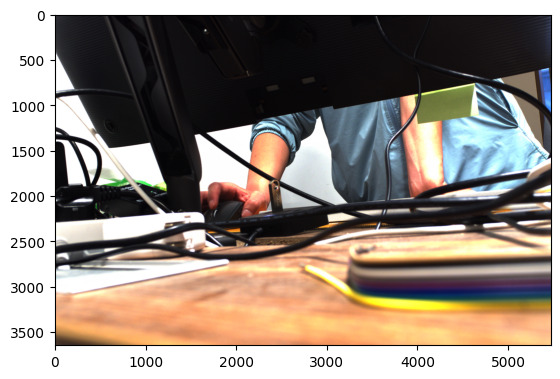

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt  
plt.imshow(image)
plt.show()